In [25]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [31]:
train_dg = ImageDataGenerator(rescale=1/255.,
                             rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
test_dg = ImageDataGenerator(rescale=1/255.,
                             rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [33]:
train_generator = train_dg.flow_from_directory('train/', target_size=(128,128), batch_size=16)
valid_generator = test_dg.flow_from_directory('test/', target_size=(128,128), batch_size=16)

Found 3255 images belonging to 21 classes.
Found 945 images belonging to 21 classes.


In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (128,128,3), 
                                               include_top = False,
                                               weights = "imagenet")

In [36]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [37]:
base_model.trainable = True

In [38]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [40]:
dropout_layer = tf.keras.layers.Dropout(0.5)(global_average_layer)

In [41]:
prediction_layer = tf.keras.layers.Dense(units = 21, activation = "softmax", kernel_regularizer=regularizers.l2(0.01))(dropout_layer)

In [43]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss="categorical_crossentropy", metrics = ["accuracy"])

In [65]:
model.fit(train_generator, epochs=25, validation_data=valid_generator)

Epoch 1/25
204/204 [==============================] - 15s 71ms/step - loss: 0.8147 - accuracy: 0.8479 - val_loss: 1.2252 - val_accuracy: 0.7386
Epoch 2/25
204/204 [==============================] - 14s 69ms/step - loss: 0.8031 - accuracy: 0.8525 - val_loss: 1.2635 - val_accuracy: 0.7344
Epoch 3/25
204/204 [==============================] - 14s 70ms/step - loss: 0.8172 - accuracy: 0.8445 - val_loss: 1.2566 - val_accuracy: 0.7302
Epoch 4/25
204/204 [==============================] - 15s 72ms/step - loss: 0.7742 - accuracy: 0.8571 - val_loss: 1.2626 - val_accuracy: 0.7344
Epoch 5/25
204/204 [==============================] - 15s 72ms/step - loss: 0.7929 - accuracy: 0.8547 - val_loss: 1.2403 - val_accuracy: 0.7524
Epoch 6/25
204/204 [==============================] - 15s 75ms/step - loss: 0.7778 - accuracy: 0.8565 - val_loss: 1.2434 - val_accuracy: 0.7524
Epoch 7/25
204/204 [==============================] - 15s 74ms/step - loss: 0.8092 - accuracy: 0.8430 - val_loss: 1.2739 - val_accuracy:

In [67]:
images_list = []
labels_list = []

# Iterar sobre o gerador e armazenar as imagens e os rótulos
for i in range(len(valid_generator)):
    # Obter lote de imagens e rótulos
    images, labels = valid_generator[i]
    # Verificar se os lotes são arrays NumPy e têm as formas esperadas
    if isinstance(images, np.ndarray) and images.ndim == 4 and isinstance(labels, np.ndarray):
        images_list.append(images)
        labels_list.append(labels)
    else:
        print(f"Lote {i} não é válido. Ignorando.")

# Concatenar todas as imagens e rótulos em arrays únicos
if images_list and labels_list:
    images_array = np.concatenate(images_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    print(f"Shape do array de imagens: {images_array.shape}")
    print(f"Shape do array de rótulos: {labels_array.shape}")
else:
    print("Nenhuma imagem ou rótulo foi processado corretamente.")

Shape do array de imagens: (945, 128, 128, 3)
Shape do array de rótulos: (945, 21)


In [68]:
pred = model.predict(images_array)
pred = np.argmax(pred, axis=1)

labels_array = np.argmax(labels_array, axis=1)

30/30 [==============================] - 0s 11ms/step


In [69]:
cm = tf.math.confusion_matrix(labels_array, pred)

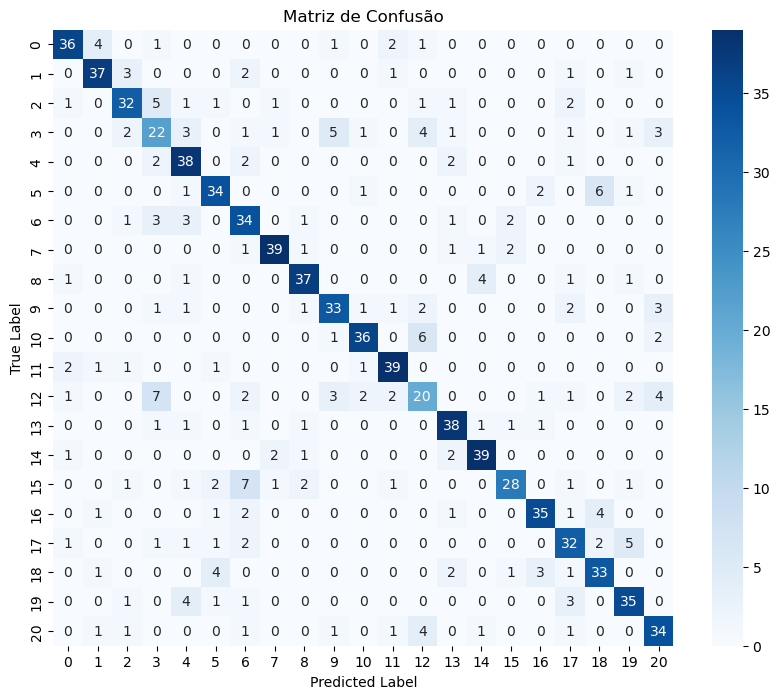

In [73]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusão')
plt.show()

In [27]:
type(valid_generator)

keras.preprocessing.image.DirectoryIterator

In [28]:
imgs, classes = valid_generator.__getitem__(0)

In [29]:
classes

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

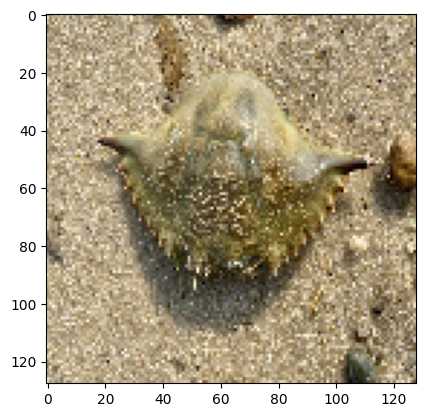

In [51]:
plt.imshow(imgs[8])

In [53]:
model.predict(tf.expand_dims(imgs[5], axis=0))

1/1 [==============================] - 0s 21ms/step


array([[0.088126  , 0.7170773 , 0.19479665]], dtype=float32)